In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
import re
import string
import gdown

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [2]:
#Read the dataset saved in my Google Drive
df_fake = pd.read_csv("https://drive.usercontent.google.com/uc?id=1O7_aLYFREQ0_eq9SHfRPyua3Eg-XCwJH&authuser=0&export=download")
df_true = pd.read_csv("https://drive.usercontent.google.com/uc?id=1vbQq9bCGrbkqCfEvEYp1SsyZXNbmv_3v&authuser=0&export=download")

In [3]:
#This display the content of each dataset
df_fake.head()
#df_true.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
#This command represent the labekl as a vector
df_fake["class"] = 1
df_true["class"] = 0

In [5]:
#This command help to know the number of rows and column of the dataset
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [8]:
#This command merge the fake and true news dataset
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.tail(100)

,title,text,subject,date,class
21317,Saudi-led force admits strike in Yemen's capit...,RIYADH (Reuters) - A Saudi-led Arab coalition ...,worldnews,"August 26, 2017",0
21318,Italy's interior minister meets Libyan mayors ...,MILAN (Reuters) - Italian Interior Minister Ma...,worldnews,"August 26, 2017",0
21319,"After Yemeni air strike, little girl is family...",SANAA (Reuters) - Her bruised eyes still swoll...,worldnews,"August 26, 2017",0
21320,Man with sword injures police outside UK Queen...,(Reuters) - A man who assaulted police officer...,worldnews,"August 25, 2017",0
21321,Chinese government advisor says more Mandarin ...,BEIJING (Reuters) - Not enough effort is being...,worldnews,"August 26, 2017",0
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [9]:
#This command remove title, subject and date column from the merged dataset
df = df_merge.drop(["title", "subject","date"], axis = 1)

In [10]:
# This gives the count of missing values for each column in the  DataFrame
df.isnull().sum()

text     0
class    0
dtype: int64

In [11]:
# This function shuffles the rows of the DataFrame
df = df.sample(frac = 1, random_state=28)

In [12]:
df.head()

,text,class
11284,ABUJA (Reuters) - The United States has formal...,0
3458,HAVANA/WASHINGTON (Reuters) - U.S. cruise oper...,0
1963,Years of racism in the workplace has finally r...,1
20361,TOKYO (Reuters) - Japanese Prime Minister Shin...,0
10430,WASHINGTON (Reuters) - Technology companies co...,0


In [14]:
#The command reset the index of a DataFrame and drop the initial index column
df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)

In [15]:
#This command print the header
df.columns


Index(['text', 'class'], dtype='object')

In [16]:
# This command clean and normalize text data.
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [17]:
#This command removes some words from text like stopwords
df["text"] = df["text"].apply(wordopt)

In [19]:
# This allows the model to learn patterns in the text data(x) and make predictions (y_pred)
x = df["text"]
y = df["class"]

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [21]:
#Checking the number of data in both train dataset and tt dataset
x_train.count()
#x_test.count()

35918

In [22]:
# Spliting the training dataset into training(x_train ) and validation dataset(y_train)
x_val = x_train[:15000]
partial_x_train = x_train[15000:]

y_val = y_train[:15000]
partial_y_train = y_train[15000:]

In [23]:
#FIRST MODEL
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(x_train[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.76108277, -0.18823484, -0.5689146 ,  0.8851863 , -0.21879557,
        -0.19806452,  0.21696456, -0.25168607, -0.5620835 ,  0.23777992,
         0.14647941,  0.50328124, -0.20585282,  0.23120186, -0.50203246,
        -0.15600213, -0.76256895,  0.38791952,  0.5974327 , -1.6537651 ,
         0.01168246,  0.0057331 ,  1.0835564 ,  0.45403233, -0.32449636,
         1.0742334 , -1.9532454 , -0.0869683 ,  0.50512415, -0.7241683 ,
        -0.8490721 ,  0.48971552,  0.949789  , -0.33658463, -0.96229845,
         0.38842472,  0.30453095, -0.24919307,  0.28209615, -1.3521937 ,
         0.19385213,  0.83929294, -0.09159798,  0.3741575 , -0.66936535,
        -0.63066924, -0.81971467, -0.3966134 ,  0.5555791 , -0.08410921],
       [ 0.90036345,  0.03579783, -0.40965158, -0.032384  , -0.04979572,
        -0.11461169,  0.29678074, -0.00363099, -0.22277106,  0.7279978 ,
         0.1980441 ,  0.57739025, -0.06877492, -0.07662243, -0.5305635 ,
 

In [ ]:
#SECOND MODEL
#model = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
#hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
#hub_layer(x_train[:3])

In [ ]:
#THIRD MODEL
#model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
#hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
#hub_layer(x_train[:3])

In [24]:
#This command to build the model using some hyperparameters
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48192265 (183.84 MB)
Trainable params: 48192265 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [26]:
#This command use the fit method to train the tensorflow model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
41/41 [==============================] - 68s 2s/step - loss: 0.4351 - accuracy: 0.8522 - val_loss: 0.2553 - val_accuracy: 0.9221
Epoch 2/10
41/41 [==============================] - 69s 2s/step - loss: 0.1728 - accuracy: 0.9503 - val_loss: 0.1249 - val_accuracy: 0.9633
Epoch 3/10
41/41 [==============================] - 67s 2s/step - loss: 0.0824 - accuracy: 0.9779 - val_loss: 0.0765 - val_accuracy: 0.9775
Epoch 4/10
41/41 [==============================] - 83s 2s/step - loss: 0.0449 - accuracy: 0.9895 - val_loss: 0.0567 - val_accuracy: 0.9825
Epoch 5/10
41/41 [==============================] - 72s 2s/step - loss: 0.0270 - accuracy: 0.9954 - val_loss: 0.0463 - val_accuracy: 0.9863
Epoch 6/10
41/41 [==============================] - 69s 2s/step - loss: 0.0169 - accuracy: 0.9978 - val_loss: 0.0409 - val_accuracy: 0.9872
Epoch 7/10
41/41 [==============================] - 69s 2s/step - loss: 0.0110 - accuracy: 0.9989 - val_loss: 0.0381 - val_accuracy: 0.9877
Epoch 8/10
41/41 [==

In [27]:
#This is evaluating the model with the whole test datatest
results = model.evaluate(x_test, y_test)

print(results)

281/281 [==============================] - 53s 190ms/step - loss: 0.0391 - accuracy: 0.9881
[0.039063140749931335, 0.988084614276886]


In [28]:
#This is predicting the label for the test dataset
results_pred = model.predict(x_test)
classes_x=np.argmax(results_pred ,axis=1)

281/281 [==============================] - 54s 189ms/step


In [29]:
#This commnd help to create a library which has the training history of the model
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

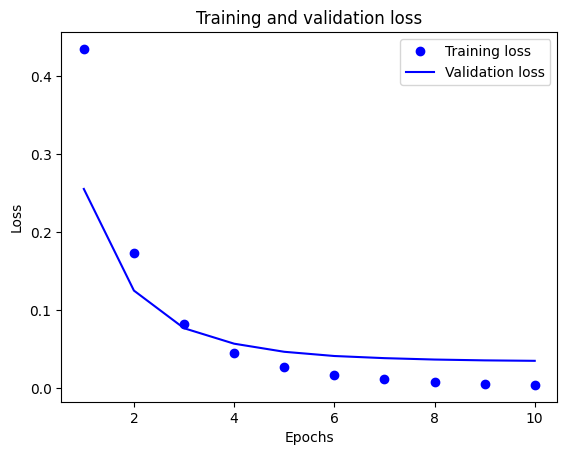

In [30]:
#This command shows  the loss changes over the training process and whether the model is overfitting or underfitting.
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

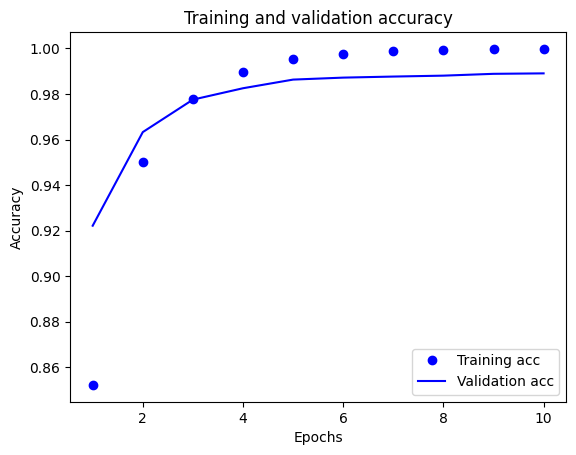

In [31]:
#the command plots the graph that shows the  training and validation accuracy
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, ConfusionMatrixDisplay

y_pred = np.where(results_pred > 0.5, 1, 0)

# Calculate the performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print model performance
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)
print("Confusion Matrix: ", confusion)

# Create a ConfusionMatrixDisplay object with the confusion matrix and display labels
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[0, 1])


Accuracy:  0.9870824053452116
Precision:  0.993577392421323
Recall:  0.9818066426909244
F1:  0.9876569482868696
Confusion Matrix:  [[4223   30]
 [  86 4641]]


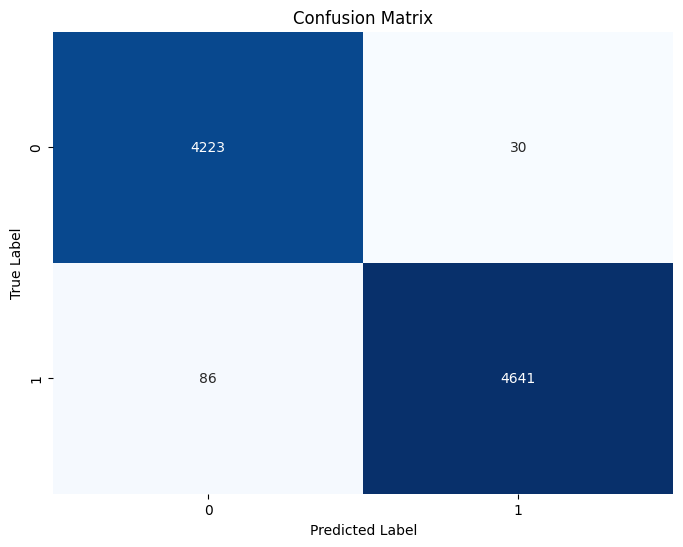

In [33]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels (replace with your actual class labels if not numerical)
class_labels = np.unique(np.concatenate((y_test, classes_x)))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
